<a href="https://colab.research.google.com/github/Mugunthan98/DS677Project/blob/main/DALLE2(OpenAI_CLIP).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### 1: Setup Environment
!pip install numpy==1.24.3 --upgrade --quiet
!pip install dalle2-pytorch
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install transformers datasets


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-47f8y4k2
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-47f8y4k2
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [2]:
### 2: Import Required Libraries

import torch
from dalle2_pytorch import DALLE2, DiffusionPriorNetwork, DiffusionPrior, Unet, Decoder, OpenAIClipAdapter
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import random


# >> Load Flickr8k Dataset:

In [3]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
### Set Paths and Preview Caption File

image_dir = "/content/drive/MyDrive/Flickr8k/Flickr8k/images"
caption_file = "/content/drive/MyDrive/Flickr8k/Flickr8k/captions.txt"

# Preview a few lines from captions.txt
with open(caption_file, 'r') as f:
    for _ in range(5):
        print(f.readline().strip())


1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


In [5]:
###  Build Caption Dictionary

from collections import defaultdict

captions_dict = defaultdict(list)
with open(caption_file, 'r') as f:
    for line in f:
        if "\t" not in line:
            continue
        img_caption = line.strip().split('\t')
        if len(img_caption) != 2:
            continue
        img, caption = img_caption
        img_name = img.split('#')[0]
        captions_dict[img_name].append(caption)

# Print example
sample_img = list(captions_dict.keys())[0]
print(f"Image: {sample_img}")
print("Captions:", captions_dict[sample_img])


Image: 1000268201_693b08cb0e.jpg
Captions: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


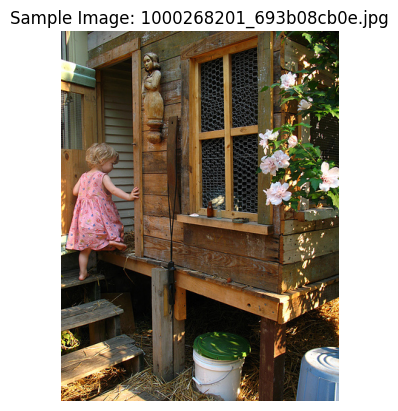

In [7]:
### Load and Show Image
from PIL import Image
import os
import matplotlib.pyplot as plt

# Construct image path
img_path = os.path.join(image_dir, sample_img)

# Load and convert image
image = Image.open(img_path).convert("RGB")

# Display using matplotlib (works in Colab)
plt.imshow(image)
plt.title(f"Sample Image: {sample_img}")
plt.axis("off")
plt.show()


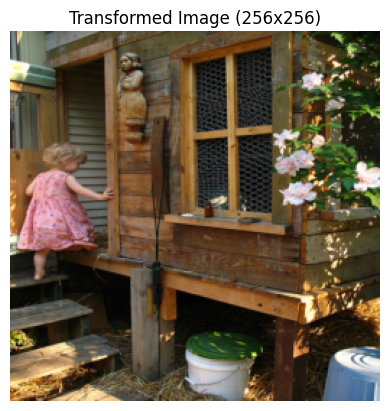

In [8]:
###  Define Transform and Visual Test

from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

tensor_image = transform(image)

# Visual check (matplotlib)
plt.imshow(tensor_image.permute(1, 2, 0))
plt.title("Transformed Image (256x256)")
plt.axis('off')
plt.show()


In [9]:
###  Create Data Batch Loader

import random
import torch

def get_batch_from_drive(batch_size=4):
    img_names = random.sample(list(captions_dict.keys()), batch_size)
    images = []
    texts = []

    for img_name in img_names:
        img_path = os.path.join(image_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        images.append(transform(image))
        texts.append(random.choice(captions_dict[img_name]))

    images = torch.stack(images).cuda()

    # Tokenize using CLIP
    import clip
    _, _ = clip.load("ViT-B/32", device="cuda")
    tokens = clip.tokenize(texts).cuda()

    return tokens, images, texts


In [10]:
###  Test the Batch Function

tokens, images, texts = get_batch_from_drive(batch_size=2)

print("Token shape:", tokens.shape)   # Expected: (2, 77)
print("Image batch shape:", images.shape)  # Expected: (2, 3, 256, 256)
print("Sample captions:", texts)


100%|███████████████████████████████████████| 338M/338M [00:11<00:00, 29.5MiB/s]


Token shape: torch.Size([2, 77])
Image batch shape: torch.Size([2, 3, 256, 256])
Sample captions: ['The man is performing a trick on a skateboard near onlookers .', 'A small white dog stands on one leg to catch a ball .']


In [11]:
###  Initialize DiffusionPrior and Decoder

from dalle2_pytorch import DiffusionPriorNetwork, DiffusionPrior, OpenAIClipAdapter

clip_adapter = OpenAIClipAdapter().cuda()

prior_network = DiffusionPriorNetwork(
    dim=512,
    depth=6,
    dim_head=64,
    heads=8
).cuda()

diffusion_prior = DiffusionPrior(
    net=prior_network,
    clip=clip_adapter,
    timesteps=100,
    cond_drop_prob=0.2
).cuda()


In [12]:
###  Initialize Decoder with U-Nets

from dalle2_pytorch import Unet, Decoder

unet1 = Unet(
    dim=128,
    image_embed_dim=512,
    cond_dim=128,
    channels=3,
    dim_mults=(1, 2, 4, 8),
    text_embed_dim=512,
    cond_on_text_encodings=True
).cuda()

unet2 = Unet(
    dim=16,
    image_embed_dim=512,
    cond_dim=128,
    channels=3,
    dim_mults=(1, 2, 4, 8, 16)
).cuda()

decoder = Decoder(
    unet=(unet1, unet2),
    image_sizes=(128, 256),
    clip=clip_adapter,
    timesteps=1000,
    sample_timesteps=(250, 27),
    image_cond_drop_prob=0.1,
    text_cond_drop_prob=0.5
).cuda()


In [13]:
###  Single Training Step to Verify All Components

from torch.optim import Adam

# Define optimizers
prior_optim = Adam(diffusion_prior.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=1e-4)

# Get sample batch
tokens, images, _ = get_batch_from_drive(batch_size=2)

# ---- Train Prior ----
prior_optim.zero_grad()
loss_prior = diffusion_prior(tokens, images)
print("Prior Loss:", loss_prior.item())
loss_prior.backward()
prior_optim.step()

# ---- Train Decoder ----
for unet_number in (1, 2):
    decoder_optim.zero_grad()
    loss_decoder = decoder(images, text=tokens, unet_number=unet_number)
    print(f"Decoder Loss (UNet {unet_number}):", loss_decoder.item())
    loss_decoder.backward()
    decoder_optim.step()


Prior Loss: 1.339957356452942
Decoder Loss (UNet 1): 1.0046335458755493
Decoder Loss (UNet 2): 1.001086950302124


sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/27 [00:00<?, ?it/s]

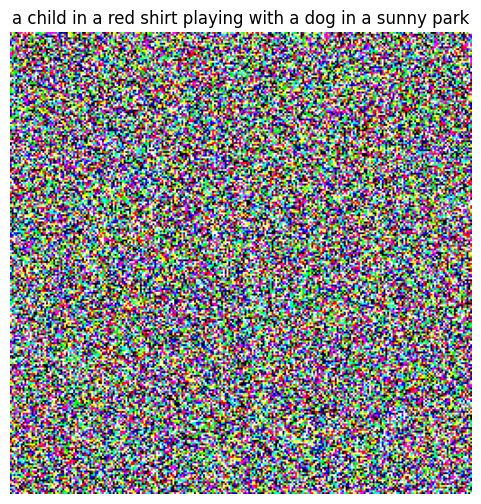

In [14]:
### Generate Image from Text Caption

from dalle2_pytorch import DALLE2
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Assemble DALLE2
dalle2 = DALLE2(
    prior=diffusion_prior,
    decoder=decoder
)

# Define your caption
caption = ["a child in a red shirt playing with a dog in a sunny park"]

# Generate image
generated_images = dalle2(caption, cond_scale=2.0)  # guidance scale > 1 strengthens conditioning

# Display
grid_img = make_grid(generated_images, nrow=1)
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title(caption[0])
plt.show()


In [15]:
### 100-Step Training Loop for DALLE-2

from tqdm import tqdm
import torch

# Define optimizers
prior_optim = Adam(diffusion_prior.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=1e-4)

# Number of training steps
num_steps = 100

print("Starting 100-step training loop...\n")

for step in tqdm(range(1, num_steps + 1), desc="Training Step"):

    # Get training batch
    tokens, images, _ = get_batch_from_drive(batch_size=4)

    # --- Train Prior ---
    prior_optim.zero_grad()
    loss_prior = diffusion_prior(tokens, images)
    loss_prior.backward()
    prior_optim.step()

    # --- Train Decoder (UNet 1 and 2) ---
    for unet_number in (1, 2):
        decoder_optim.zero_grad()
        loss_decoder = decoder(images, text=tokens, unet_number=unet_number)
        loss_decoder.backward()
        decoder_optim.step()

    # --- Log every 10 steps ---
    if step % 10 == 0 or step == 1:
        with torch.no_grad():
            print(f"[Step {step:>3}] Prior Loss       : {loss_prior.item():.4f}")
            print(f"           Decoder Loss (U1): {loss_decoder.item():.4f}\n")


Starting 100-step training loop...



Training Step:   1%|          | 1/100 [00:06<09:55,  6.01s/it]

[Step   1] Prior Loss       : 1.1519
           Decoder Loss (U1): 1.0022



Training Step:  10%|█         | 10/100 [00:58<08:39,  5.78s/it]

[Step  10] Prior Loss       : 0.6274
           Decoder Loss (U1): 1.0002



Training Step:  20%|██        | 20/100 [01:54<07:28,  5.61s/it]

[Step  20] Prior Loss       : 0.4922
           Decoder Loss (U1): 0.9909



Training Step:  30%|███       | 30/100 [02:53<06:50,  5.86s/it]

[Step  30] Prior Loss       : 0.4900
           Decoder Loss (U1): 0.9875



Training Step:  40%|████      | 40/100 [03:49<05:35,  5.60s/it]

[Step  40] Prior Loss       : 0.4755
           Decoder Loss (U1): 0.9797



Training Step:  50%|█████     | 50/100 [04:47<04:49,  5.80s/it]

[Step  50] Prior Loss       : 0.4834
           Decoder Loss (U1): 0.9697



Training Step:  60%|██████    | 60/100 [05:45<03:52,  5.80s/it]

[Step  60] Prior Loss       : 0.3939
           Decoder Loss (U1): 0.9469



Training Step:  70%|███████   | 70/100 [06:41<02:50,  5.68s/it]

[Step  70] Prior Loss       : 0.5023
           Decoder Loss (U1): 0.9211



Training Step:  80%|████████  | 80/100 [07:39<01:54,  5.70s/it]

[Step  80] Prior Loss       : 0.5784
           Decoder Loss (U1): 0.8900



Training Step:  90%|█████████ | 90/100 [08:39<00:59,  5.94s/it]

[Step  90] Prior Loss       : 0.4216
           Decoder Loss (U1): 0.8618



Training Step: 100%|██████████| 100/100 [09:40<00:00,  5.80s/it]

[Step 100] Prior Loss       : 0.4427
           Decoder Loss (U1): 0.8214



sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/27 [00:00<?, ?it/s]

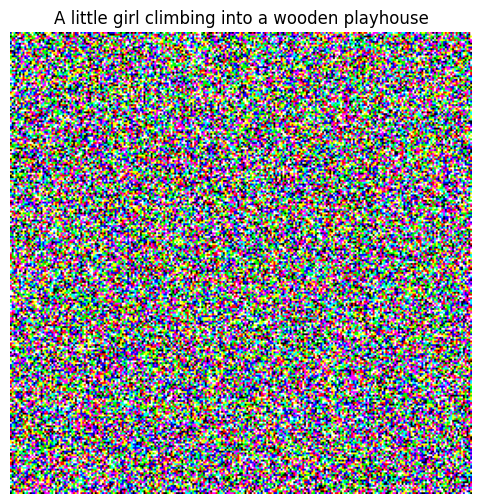

In [17]:
###   Generate Image From Trained Model

from dalle2_pytorch import DALLE2
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Assemble DALLE-2 with trained components
dalle2 = DALLE2(
    prior=diffusion_prior,
    decoder=decoder
)

# Example test caption (can be anything from Flickr8k captions.txt)
caption = ["A little girl climbing into a wooden playhouse"]

# Generate image
generated_images = dalle2(caption, cond_scale=2.0)

# Display output
grid_img = make_grid(generated_images, nrow=1)
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title(caption[0])
plt.show()


In [18]:
###  1000-Step Training Loop for DALLE-2

from tqdm import tqdm
import torch

# Define optimizers
prior_optim = Adam(diffusion_prior.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=1e-4)

# Number of training steps
num_steps = 1000

print("Starting 1000-step training loop...\n")

for step in tqdm(range(1, num_steps + 1), desc="Training Step"):

    # Get training batch
    tokens, images, _ = get_batch_from_drive(batch_size=4)

    # --- Train Prior ---
    prior_optim.zero_grad()
    loss_prior = diffusion_prior(tokens, images)
    loss_prior.backward()
    prior_optim.step()

    # --- Train Decoder (UNet 1 and 2) ---
    for unet_number in (1, 2):
        decoder_optim.zero_grad()
        loss_decoder = decoder(images, text=tokens, unet_number=unet_number)
        loss_decoder.backward()
        decoder_optim.step()

    # --- Log every 50 steps ---
    if step % 50 == 0 or step == 1:
        with torch.no_grad():
            print(f"[Step {step:>3}] Prior Loss       : {loss_prior.item():.4f}")
            print(f"           Decoder Loss (U1): {loss_decoder.item():.4f}\n")


Starting 1000-step training loop...



Training Step:   0%|          | 1/1000 [00:05<1:34:31,  5.68s/it]

[Step   1] Prior Loss       : 0.5438
           Decoder Loss (U1): 0.8426



Training Step:   5%|▌         | 50/1000 [04:48<1:28:44,  5.60s/it]

[Step  50] Prior Loss       : 0.4798
           Decoder Loss (U1): 0.6908



Training Step:  10%|█         | 100/1000 [09:30<1:25:23,  5.69s/it]

[Step 100] Prior Loss       : 0.5200
           Decoder Loss (U1): 0.5557



Training Step:  15%|█▌        | 150/1000 [14:12<1:16:37,  5.41s/it]

[Step 150] Prior Loss       : 0.5500
           Decoder Loss (U1): 0.4337



Training Step:  20%|██        | 200/1000 [18:57<1:23:50,  6.29s/it]

[Step 200] Prior Loss       : 0.4604
           Decoder Loss (U1): 0.3123



Training Step:  25%|██▌       | 250/1000 [23:36<1:05:42,  5.26s/it]

[Step 250] Prior Loss       : 0.4926
           Decoder Loss (U1): 0.2734



Training Step:  30%|███       | 300/1000 [28:23<1:05:18,  5.60s/it]

[Step 300] Prior Loss       : 0.3913
           Decoder Loss (U1): 0.2014



Training Step:  35%|███▌      | 350/1000 [33:04<1:02:10,  5.74s/it]

[Step 350] Prior Loss       : 0.3872
           Decoder Loss (U1): 0.1226



Training Step:  40%|████      | 400/1000 [37:41<56:19,  5.63s/it]

[Step 400] Prior Loss       : 0.3562
           Decoder Loss (U1): 0.0590



Training Step:  45%|████▌     | 450/1000 [42:21<51:35,  5.63s/it]

[Step 450] Prior Loss       : 0.3318
           Decoder Loss (U1): 0.0272



Training Step:  50%|█████     | 500/1000 [47:00<47:25,  5.69s/it]

[Step 500] Prior Loss       : 0.4307
           Decoder Loss (U1): 0.0212



Training Step:  55%|█████▌    | 550/1000 [51:36<42:15,  5.63s/it]

[Step 550] Prior Loss       : 0.4189
           Decoder Loss (U1): 0.0232



Training Step:  60%|██████    | 600/1000 [56:15<37:28,  5.62s/it]

[Step 600] Prior Loss       : 0.4421
           Decoder Loss (U1): 0.1012



Training Step:  65%|██████▌   | 650/1000 [1:00:48<30:17,  5.19s/it]

[Step 650] Prior Loss       : 0.4481
           Decoder Loss (U1): 0.0286



Training Step:  70%|███████   | 700/1000 [1:04:53<24:36,  4.92s/it]

[Step 700] Prior Loss       : 0.5279
           Decoder Loss (U1): 0.0369



Training Step:  75%|███████▌  | 750/1000 [1:09:21<22:13,  5.34s/it]

[Step 750] Prior Loss       : 0.5173
           Decoder Loss (U1): 0.0122



Training Step:  80%|████████  | 800/1000 [1:13:51<17:12,  5.16s/it]

[Step 800] Prior Loss       : 0.4207
           Decoder Loss (U1): 0.2200



Training Step:  85%|████████▌ | 850/1000 [1:18:22<13:46,  5.51s/it]

[Step 850] Prior Loss       : 0.3778
           Decoder Loss (U1): 0.0147



Training Step:  90%|█████████ | 900/1000 [1:22:57<09:03,  5.44s/it]

[Step 900] Prior Loss       : 0.4218
           Decoder Loss (U1): 0.0091



Training Step:  95%|█████████▌| 950/1000 [1:27:24<04:32,  5.44s/it]

[Step 950] Prior Loss       : 0.4265
           Decoder Loss (U1): 0.0341



Training Step: 100%|██████████| 1000/1000 [1:31:48<00:00,  5.51s/it]

[Step 1000] Prior Loss       : 0.3677
           Decoder Loss (U1): 0.0086



sampling loop time step:   0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

sampling loop time step:   0%|          | 0/27 [00:00<?, ?it/s]

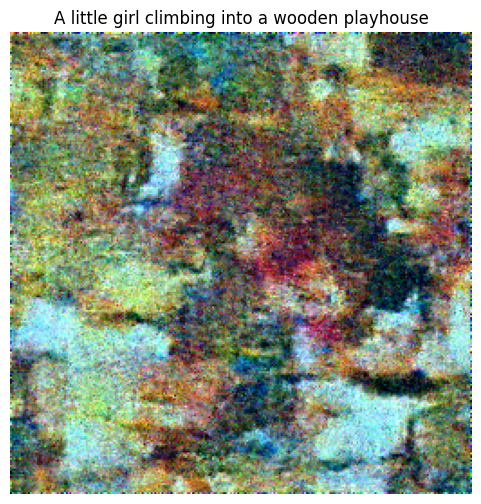

In [19]:
###  Generate Image From Trained Model

from dalle2_pytorch import DALLE2
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Assemble DALLE-2 with trained components
dalle2 = DALLE2(
    prior=diffusion_prior,
    decoder=decoder
)

# Example test caption (can be anything from Flickr8k captions.txt)
caption = ["A little girl climbing into a wooden playhouse"]

# Generate image
generated_images = dalle2(caption, cond_scale=2.0)

# Display output
grid_img = make_grid(generated_images, nrow=1)
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title(caption[0])
plt.show()


In [ ]:
###  5000-Step Training Loop for DALLE-2

from tqdm import tqdm
import torch

# Define optimizers
prior_optim = Adam(diffusion_prior.parameters(), lr=1e-4)
decoder_optim = Adam(decoder.parameters(), lr=1e-4)

# Number of training steps
num_steps = 5000

print("Starting 5000-step training loop...\n")

for step in tqdm(range(1, num_steps + 1), desc="Training Step"):

    # Get training batch
    tokens, images, _ = get_batch_from_drive(batch_size=4)

    # --- Train Prior ---
    prior_optim.zero_grad()
    loss_prior = diffusion_prior(tokens, images)
    loss_prior.backward()
    prior_optim.step()

    # --- Train Decoder (UNet 1 and 2) ---
    for unet_number in (1, 2):
        decoder_optim.zero_grad()
        loss_decoder = decoder(images, text=tokens, unet_number=unet_number)
        loss_decoder.backward()
        decoder_optim.step()

    # --- Log every 100 steps ---
    if step % 100 == 0 or step == 1:
        with torch.no_grad():
            print(f"[Step {step:>3}] Prior Loss       : {loss_prior.item():.4f}")
            print(f"           Decoder Loss (U1): {loss_decoder.item():.4f}\n")


In [ ]:
###  Generate Image From Trained Model

from dalle2_pytorch import DALLE2
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Assemble DALLE-2 with trained components
dalle2 = DALLE2(
    prior=diffusion_prior,
    decoder=decoder
)

# Example test caption (can be anything from Flickr8k captions.txt)
caption = ["A little girl climbing into a wooden playhouse"]

# Generate image
generated_images = dalle2(caption, cond_scale=2.0)

# Display output
grid_img = make_grid(generated_images, nrow=1)
plt.figure(figsize=(6, 6))
plt.imshow(grid_img.permute(1, 2, 0).cpu())
plt.axis('off')
plt.title(caption[0])
plt.show()